Import Libraries

Here we import necessary libraries for mathematical calculations and plotting.


In [3]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling import models, fitting
from scipy import ndimage, stats, optimize
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit, least_squares, leastsq
import glob
import os
from numpy import exp  # Exponential function for Gaussian calculations
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.family'] = "Serif"

# Function Definitions-

Function 1: Calculate redshift from velocity
This function calculates the redshift, which measures how much the wavelength of light is stretched due to an object's motion away from the observer.

Inputs:
- vel: The velocity of the object in km/s.

Steps:
   Divide the object's velocity by the speed of light (300,000 km/s) to calculate the redshift:
   redshift = vel / 300,000

Output:
The redshift value, which indicates the fractional increase in wavelength due to the object's motion.

In [7]:
def redshift(vel):
    """
    Calculate redshift based on the velocity of an object.

    Parameters:
    vel (float): Velocity in km/s

    Returns:
    float: Redshift value
    """
    return vel / 300000.0  # Divide velocity by the speed of light (in km/s)

Function 2: Calculate line width (sigma) from velocity dispersion
This function calculates the observed width of a spectral line (sigma) by combining the broadening from the object's velocity dispersion and the instrumental resolution.

Inputs:
- vel_sigma: The velocity dispersion of the object in km/s.
- rest_line: The rest-frame wavelength of the spectral line in Angstroms.
- inst_res_fwhm: The instrument's resolution in Angstroms (FWHM).

Steps:
1. Convert velocity dispersion to wavelength broadening using the formula:
   sigma_object = (vel_sigma / 300,000) * rest_line
   where 300,000 is the speed of light in km/s.

2. Convert the instrument's resolution (FWHM) to sigma using:
   sigma_instrument = inst_res_fwhm / 2.354

3. Combine the intrinsic and instrumental broadening using:
   total_sigma = sqrt(sigma_object^2 + sigma_instrument^2)

Output:
The total line width (sigma) in Angstroms, accounting for both effects.

In [8]:
def line_width(vel_sigma, rest_line, inst_res_fwhm):
    """
    Calculate the total line width (sigma), accounting for both intrinsic width and instrument resolution.

    Parameters:
    vel_sigma (float): Velocity dispersion in km/s
    rest_line (float): Rest-frame wavelength of the emission line (in Angstroms)
    inst_res_fwhm (float): Instrument resolution (Full Width at Half Maximum)

    Returns:
    float: Total line width (sigma) in Angstroms
    """
    sigma = vel_sigma / (300000.0 - vel_sigma) * rest_line  # Convert velocity dispersion to wavelength dispersion
    return np.sqrt(sigma**2 + (inst_res_fwhm / 2.354)**2)  # Combine intrinsic and instrument effects

Function 3: Generate a Gaussian profile
This function creates a Gaussian profile to model an emission or absorption line in a spectrum. It accounts for the line's peak intensity, position, width, and instrumental effects.

1. The input `wave` is the array of wavelengths where the profile will be evaluated.
2. The `amplitude` specifies the height of the Gaussian peak, representing the line's intensity.
3. The `vel` shifts the line's rest wavelength (`rest_wave`) to account for Doppler effects, using the `redshift` function.
4. The `vel_sigma` represents the velocity dispersion of the source, which determines the line's width in combination with the instrumental resolution (`inst_res_fwhm`).
5. The formula `exp(-(wave - redshifted_wave)**2 / (2 * sigma**2))` generates a symmetric Gaussian curve centered on the Doppler-shifted wavelength with a width (`sigma`) calculated by `line_width`.

The output is a Gaussian profile as an array, describing how the line's intensity varies with wavelength.

In [62]:
def Hb_model_single(wave, amp_Hb_core, vel_core, vel_sigma_core, m, c):
    """
    Model H-beta and OIII lines with Gaussian profiles, including a continuum.

    Parameters:
    wave (array): Wavelength array (in Angstroms)
    amp_Hb_core (float): Amplitude of the core component of H-beta
    vel_core (float): Velocity shift for core components (in km/s)
    vel_sigma_core (float): Velocity dispersion for core components (in km/s)
    m (float): Slope of the linear continuum
    c (float): Intercept of the linear continuum

    Returns:
    array: Combined model of H-beta, OIII, and the continuum
    """
    Hb_core = gauss(wave, amp_Hb_core, vel_core, vel_sigma_core, 4861.33, 2.3)  # H-beta core
    cont = (wave / 1000) * m + c  # Linear continuum
    return Hb_core + cont

In [9]:
def gauss(wave, amplitude, vel, vel_sigma, rest_wave, inst_res_fwhm):
    """
    Generate a Gaussian line profile based on input parameters.

    Parameters:
    wave (array): Wavelength array (in Angstroms)
    amplitude (float): Peak intensity of the line
    vel (float): Velocity shift in km/s
    vel_sigma (float): Velocity dispersion in km/s
    rest_wave (float): Rest-frame wavelength of the line (in Angstroms)
    inst_res_fwhm (float): Instrument resolution (FWHM in Angstroms)

    Returns:
    array: Gaussian line profile
    """
    redshifted_wave = rest_wave * (1 + redshift(vel))  # Shift rest wavelength by velocity
    sigma = line_width(vel_sigma, rest_wave, inst_res_fwhm)  # Calculate line width (sigma)
    return amplitude * exp(-(wave - redshifted_wave)**2 / (2 * sigma**2))


Function 4: This function models the H-beta (4861.33 Å) and OIII (4959 Å, 5006.8 Å) emission lines in a spectrum. It assumes core Gaussian components dominate while wing components are zero.

1. `Hb_core`: Models the H-beta emission line core using a Gaussian centered at 4861.33 Å, with amplitude `amp_Hb_core` and velocity-related adjustments (`vel_core`, `vel_sigma_core`).

2. `OIII_core_5007`: Models the OIII line at 5006.8 Å similarly, using `amp_OIII_core` for amplitude.

3. `OIII_core_4959`: Represents the OIII line at 4959 Å. Its amplitude is scaled to 1/3 of the OIII 5007 Å line's amplitude (`0.33 * amp_OIII_core`).

4. Wing components (`Hb_wing`, `OIII_wing_4959`, `OIII_wing_5007`) are set to zero, assuming no significant broadening beyond the core.

5. `cont`: Models the linear continuum background as `(wave/1000) * m + c`, where `m` is the slope and `c` is the intercept.

The function returns the sum of the modeled H-beta, OIII lines, and the continuum.

In [66]:
 def Hb_OIII_gauss_model_single(wave, amp_Hb_core, amp_OIII_core, vel_core, vel_sigma_core, m, c):
    """
    Model H-beta and OIII lines with Gaussian profiles, including a continuum.

    Parameters:
    wave (array): Wavelength array (in Angstroms)
    amp_Hb_core (float): Amplitude of the core component of H-beta
    amp_OIII_core (float): Amplitude of the core component of OIII
    vel_core (float): Velocity shift for core components (in km/s)
    vel_sigma_core (float): Velocity dispersion for core components (in km/s)
    m (float): Slope of the linear continuum
    c (float): Intercept of the linear continuum

    Returns:
    array: Combined model of H-beta, OIII, and the continuum
    """
    Hb_core = gauss(wave, amp_Hb_core, vel_core, vel_sigma_core, 4861.33, 2.3)  # H-beta core
    OIII_core_5007 = gauss(wave, amp_OIII_core, vel_core, vel_sigma_core, 5006.8, 2.3)  # OIII core at 5007
    OIII_core_4959 = 0.33 * gauss(wave, amp_OIII_core, vel_core, vel_sigma_core, 4959, 2.3)  # OIII core at 4959
    cont = (wave / 1000) * m + c  # Linear continuum
    return Hb_core + OIII_core_5007 + OIII_core_4959 + Hb_wing + OIII_wing_4959 + OIII_wing_5007 + cont


Function 5: Model H-alpha and NII lines with single Gaussians
This function models the H-alpha (6562.8 Å) and NII (6548 Å, 6583 Å) emission lines using Gaussian profiles. It assumes each line has a single Gaussian core component:

1. H-alpha Core: Modeled using a Gaussian centered at the H-alpha rest wavelength, adjusted for velocity (`vel_core`) and width (`vel_sigma_core`).
2. NII Core Components:
   - NII 6548 Å: Its amplitude is scaled by `1/2.61` relative to the NII 6583 Å line.
   - NII 6583 Å: Modeled as a Gaussian using the provided parameters.
3. Linear Continuum: A simple straight line is added to represent background continuum emission using the slope (`m`) and intercept (`c`).

The function outputs the sum of these components, providing a combined model for H-alpha, NII, and the continuum.

# Load and read a spectral file

In [14]:
data=np.loadtxt('/Users/mainaksingha/Downloads/CIDER/J132152+472746.txt')
ivar=data.T[2]

The np.loadtxt() function reads the file containing the spectrum data.

The file contains columns for flux, log_wavelength, and inverse variance.

The data is stored as a 2D array where each row corresponds to a single data point.


In [27]:
flux=data.T[0]

data.T transposes the array, swapping rows and columns.

The first column (index 0) corresponds to the flux values, which measure the brightness at each wavelength.

This is extracted and stored in the variable flux.

In [25]:
log_lam=data.T[1]

Extract logarithmic wavelength:

The second column (index 1) contains the logarithm (base 10) of the wavelength values.

These logarithmic values are stored in log_lam.

In [28]:
wav=10**log_lam

The logarithmic wavelength values are exponentiated (base 10) to get the actual wavelength (wav) in microns or another unit.

The resulting array represents the wavelengths in physical space.

In [29]:
ivar = data.T[2]

The third column (index 2) contains the inverse variance (1 / noise²), representing the data's uncertainty.

Notes on redshifting and de-redshifting:

The wavelengths in the file are redshifted due to the motion of the object.

The observable range is between 1 and 1.93 microns.

After extracting the data, the redshift can be used to "de-redshift" the wavelengths, restoring them to their original rest-frame values.

This process extracts the key components—flux, wavelength, and uncertainty—from the spectrum data for further analysis.

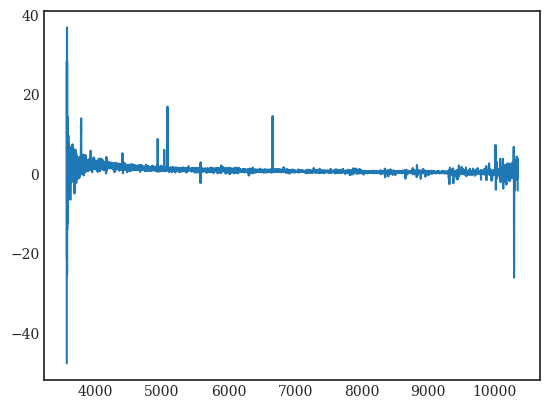

In [30]:
plt.plot(wav,flux)

This process extracts a spectum with many peak likefeatures visible. 
Those are the emission lines.


1. Galaxies:
   - Star-forming regions: Young stars ionize hydrogen gas, producing emission lines like H-alpha (6563 Å) and H-beta (4861 Å). Metal lines, like [O III] 5007 Å and [N II] 6584 Å, arise from ionized gas.

2. Active Galactic Nuclei (AGN):
   - Broad lines: High-velocity gas near the black hole produces Doppler-broadened lines like H-alpha and H-beta.
   - Narrow lines: Ionized gas in outer regions forms narrow lines like [O III] 5007 Å.
   - Highly ionized lines: X-rays create lines from elements like neon and iron.

3. Stars:
   - Hot stars: Produce hydrogen and helium emission lines.
   - Cool stars: Show molecular and metal emission lines due to lower temperatures.

(0.0, 20.0)

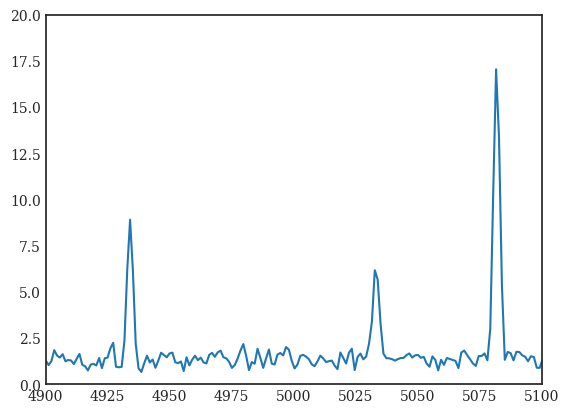

In [36]:
plt.plot(wav,flux)
plt.xlim(4900,5100)
plt.ylim(0,20)
plt.xlabel('Angstrom')
plt.ylabel('Flux density')

Now, it's time to zoom in on the emission lines. We see an emission line triplet around 5000 Angstroms, so let's focus on that.

plt.plot(wav, flux): Plots the flux (intensity) against the wavelength (in Angstroms).
    
plt.xlim(4900, 5100): Sets the x-axis limits to zoom in on the region between 4900 and 5100 Angstroms.
    
plt.ylim(0, 20): Sets the y-axis limits to adjust the vertical scale as emission line amplitudes are always positive.
    
plt.xlabel('Angstrom'): Labels the x-axis as "Angstrom" to indicate the wavelength unit.
    
plt.ylabel('Flux density'): Labels the y-axis as "Flux density" to indicate the intensity unit.

# Fitting an emission line spectrum

Yes, the triplet is clearly visible.

From left to right, the emission lines are:

Hβ: Rest-frame wavelength of 4861 Angstroms
[O III]: Rest-frame wavelength of 4959 Angstroms
[O III]: Rest-frame wavelength of 5007 Angstroms
It's important to note that there are two [O III] emission lines. 
The one at 5007 Angstroms is significantly brighter, approximately three times more than the one at 4959 Angstroms.

Since, we already know their rest-frame wavelength this gives us a great chance to directly measure its redshift.

1. The observed peak is estimated to be between 4925 Å and 4950 Å, so we assume it is around 4935 Å.
2. Redshift is calculated using the formula:
   z = (observed wavelength - rest wavelength) / rest wavelength.
3. The rest wavelength for the emission line must be known, for example, 5007 Å for [O III].
4. Using the assumed observed wavelength and the rest wavelength, calculate the redshift.
5. If the redshift estimate is inconsistent with expectations, refine the observed wavelength guess or verify the line identification.

In [75]:
# Here we estimate a best guess for the redshift

Observed_wavelength = 4935
Restframe_wavelength = 4861

Redshift= (Observed_wavelength-Restframe_wavelength)/Restframe_wavelength

print(Redshift)

0.0152232051018309


In [72]:
c=300000 #This sets the speed of light, which is a key value used to calculate redshift-related velocities.
k=1+Redshift # 

Redshift represents the redshift value (z) of the source.
The redshift factor k is calculated as 
k=1+z, which scales rest-frame wavelengths to observed wavelengths.

In [73]:
select_Hb= (wav>4830*k)&(wav<4890*k) 

This step creates a boolean mask (select_Hb) that identifies the wavelengths corresponding to the redshifted H-beta line, assuming it falls between 4830 Å and 4890 Å after scaling by the redshift factor k.


In [74]:
wav_Hb= wav[select_Hb]
flux_Hb=flux[select_Hb]

wav_Hb extracts the observed wavelengths from the wav array that fall within the selected range.

flux_Hb extracts the corresponding flux values from the flux array

In [76]:
popt_Hb,pcov_Hb=curve_fit(Hb_model_single,wav_Hb,flux_Hb,p0=[5,c*Redshift,60,0.1,0.001],maxfev=10000000)
print(popt_Hb)

[7.78655546e+00 4.48426514e+03 3.65580843e+01 1.94420345e-01
 3.06475079e-01]


curve_fit fits the Hb_model_single function (assumed to be predefined) to the extracted wavelength (wav_Hb) and flux (flux_Hb) data.

The p0 parameter provides initial guesses for the model parameters:
    
5: Initial guess for the amplitude of the H-beta line.
    
c * Redshift: Initial guess for the velocity of the line, calculated from the redshift.
    
60: Initial guess for the velocity dispersion (line width) in km/s.
    
0.1: Initial guess for a linear continuum slope.
    
0.001: Initial guess for the linear continuum intercept.
    
maxfev=10000000 ensures the fitting algorithm performs enough iterations to converge.

In [77]:
True_redshift=popt_Hb[1]/c
print(True_redshift)

0.014947550466563214


The variable popt_Hb[1] contains the velocity of the H-beta emission line in kilometers per second (km/s), as determined from the fit.

In [83]:
fitted_model=Hb_model_single(wav_Hb,popt_Hb[0],popt_Hb[1],popt_Hb[2],popt_Hb[3],popt_Hb[4])

Hb_model_single is the predefined function modeling the H-beta emission line.

The function is called with the selected wavelength values (wav_Hb) and the optimized parameters (popt_Hb) from the curve fit:
    
popt_Hb[0]: Amplitude of the H-beta line.
    
popt_Hb[1]: Velocity shift (km/s).
    
popt_Hb[2]: Velocity dispersion (km/s).
    
popt_Hb[3]: Linear continuum slope.
    
popt_Hb[4]: Linear continuum intercept.
    
The result, fitted_model, is the Gaussian model evaluated at the wavelengths wav_Hb using the best-fit parameters.

Text(0, 0.5, 'Flux density')

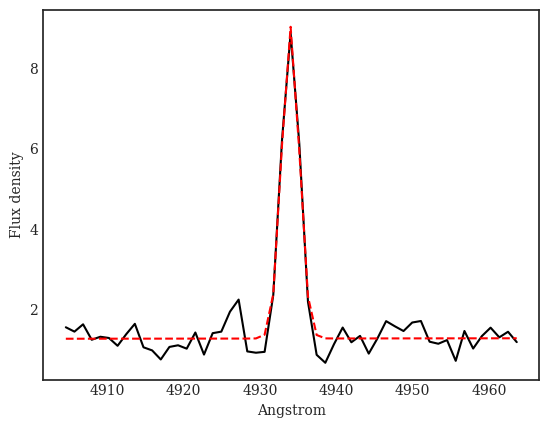

In [84]:
plt.plot(wav_Hb,flux_Hb,'k-')
plt.plot(wav_Hb,fitted_model,'r--')
plt.xlabel('Angstrom')
plt.ylabel('Flux density')

Plots the observed flux values (flux_Hb) as a function of wavelength (wav_Hb) in a black solid line ('k-').

This represents the actual data from the spectrum in the selected region around H-beta.

Plots the fitted Gaussian model (fitted_model) as a red dashed line ('r--').

This allows for a visual comparison between the observed data and the model.